# RELAX: Representation Learning Explainability

This notebook illustrates the usage of RELAX, a framework for explainability in representation learning. RELAX is based on measuring similarities in the representation space between an input and occluded versions of itself. Our analysis of RELAX shows that the proposed method can be considered a linear scoring function in a reproducing kernel Hilbert space in the form of an inner produced product between unmasked input and the mean of the masked representations. Read more here: https://arxiv.org/abs/2112.10161.

This notebook is designed to be executed in Google Colab. Remember to enable GPU acceleration through "edit-> Notebook settings -> Hardware accelerator" to speed up computation.

---

Parts of our implementation is inspired by the TorchRay package. The GitHub repo and the corresponding paper can be found at:

*   Paper: Understanding deep networks via extremal perturbations and smooth masks. Fong, Patrick, Vedaldi. ICCV 2019.
*   GitHub: https://github.com/facebookresearch/TorchRay



In [ ]:
#@title Installing Lightning Bolts
#@markdown We use the pretrained models from Lightning Bolts
#@markdown for SimCLR and SwAV, and this cell installs that package.
#@markdown Read more about Lightning Bolts at:
#@markdown https://github.com/PyTorchLightning/lightning-bolts

!pip install lightning-bolts

In [ ]:
#@title Download examples
#@markdown We download a selection of images from
#@markdown https://commons.wikimedia.org to illustrate the usage of RELAX.

!wget 'https://upload.wikimedia.org/wikipedia/commons/e/ee/Cat_in_Cat_Caf%C3%A9_Nekokaigi%2C_Tokyo%2C_February_2013.jpg'
!wget 'https://upload.wikimedia.org/wikipedia/commons/thumb/a/ae/Tringa_totanus-pjt.jpg/640px-Tringa_totanus-pjt.jpg'
!wget 'https://upload.wikimedia.org/wikipedia/commons/thumb/e/eb/Two_Cats_in_a_Corner.jpg/640px-Two_Cats_in_a_Corner.jpg'


In [ ]:
#@title Load packages


import torch
import torchvision
import torch.nn as nn
import tqdm.notebook as tqdm
import torch.nn.functional as F
import matplotlib.gridspec as gridspec

from PIL import Image
from matplotlib import pyplot as plt
from pl_bolts.models.self_supervised import SimCLR, SwAV
from torchvision.transforms.functional import pil_to_tensor
from torchvision.transforms import ToTensor, Normalize, Resize


In [ ]:
#@title Function for rescaling and displaying images.
#@markdown This function is taken from the TorchRay library.

def imsc(img, *args, quiet=False, lim=None, interpolation='lanczos', **kwargs):
    if isinstance(img, Image.Image):
        img = pil_to_tensor(img)
    handle = None
    with torch.no_grad():
        if not lim:
            lim = [img.min(), img.max()]
        img = img - lim[0]  # also makes a copy
        img.mul_(1 / (lim[1] - lim[0]))
        img = torch.clamp(img, min=0, max=1)
        if not quiet:
            bitmap = img.expand(3,
                                *img.shape[1:]).permute(1, 2, 0).cpu().numpy()
    return bitmap

In [ ]:
#@title Function for loading data
#@markdown This function loads the example images downloaded in one of the previous cells.

def load_img(img, shape=224):
    if img == 'Ex1':
        img = Image.open(
            '/content/Cat_in_Cat_Café_Nekokaigi,_Tokyo,_February_2013.jpg'
            )
    elif img == 'Ex2':
        img = Image.open(
            '/content/640px-Tringa_totanus-pjt.jpg'
            )
    elif img == 'Ex3':
        img = Image.open(
            '/content/640px-Two_Cats_in_a_Corner.jpg'
            )
    else:
        print('Incorrect keyword')
        raise

    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((shape, shape)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225]),
    ])

    x = transform(img).unsqueeze(0)

    return x.to('cuda')

In [ ]:
#@title Load feature extractors
#@markdown This cell created functions for loading the feature extractors considered
#@markdown in this notebook. Note that the supervised feature extractor is modified
#@markdown such that representation is the output of the average pooling layer.

def load_supervised():
  supervised = torchvision.models.resnet50(pretrained=True)
  modules = list(supervised.children())[:-1]
  supervised = nn.Sequential(*modules, nn.Flatten()).to('cuda')
  supervised.eval()
  return supervised

def load_swav():
  swav_weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/swav/swav_imagenet/swav_imagenet.pth.tar'
  swav = SwAV.load_from_checkpoint(swav_weight_path, strict=False)
  swav = swav.to('cuda')
  swav.eval()
  return swav


def load_simclr():
  simclr_weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt'
  simclr = SimCLR.load_from_checkpoint(simclr_weight_path, strict=False)
  simclr = simclr.to('cuda')
  simclr.eval()
  return simclr


In [ ]:
#@title Create RELAX class
#@markdown This class containts the code for RELAX. It takes an input image,
#@markdown a feautre extractor, and the number of masks used as an input.


class RELAX(nn.Module):
    def __init__(self, x, f, num_batches, batch_size):
        super().__init__()

        self.device = x.device
        self.batch_size = batch_size
        self.shape = tuple(x.shape[2:])
        self.num_batches = num_batches
        self.pdist = nn.CosineSimilarity(dim=1)

        self.x = x
        self.encoder = f
        self.h_star = f(x).expand(batch_size, -1)

        self.R = torch.zeros(self.shape, device=self.device)
        self.U = torch.zeros(self.shape, device=self.device)

        self.sum_of_weights = (1e-10)*torch.ones(self.shape, device=self.device)

    def forward(self):

        for batch in range(self.num_batches):
            for masks in self.mask_generator():

                x_mask = self.x * masks
                h = self.encoder(x_mask)
                sims = self.pdist(self.h_star, h)

                for si, mi in zip(sims, masks.squeeze()):

                    W_prev = self.sum_of_weights
                    self.sum_of_weights += mi

                    R_prev = self.R.clone()
                    self.R = self.R + mi*(si-self.R) / self.sum_of_weights
                    self.U = self.U + (si-self.R) * (si-R_prev) * mi

        return None

    def importance(self):
        return self.R

    def uncertainty(self):
        return self.U / (self.sum_of_weights - 1)

    def mask_generator(self, num_cells=7, p=0.5, nsd=2):

        pad_size = (num_cells // 2, num_cells // 2, num_cells // 2, num_cells // 2)

        grid = (torch.rand(self.batch_size, 1, *((num_cells,) * nsd), device=self.device) < p).float()
        grid_up = F.interpolate(grid, size=(self.shape), mode='bilinear', align_corners=False)
        grid_up = F.pad(grid_up, pad_size, mode='reflect')

        shift_x = torch.randint(0, num_cells, (self.batch_size,), device=self.device)
        shift_y = torch.randint(0, num_cells, (self.batch_size,), device=self.device)

        masks = torch.empty((self.batch_size, 1, self.shape[-2], self.shape[-1]), device=self.device)

        for bi in range(self.batch_size):
            masks[bi] = grid_up[bi, :,
                                shift_x[bi]:shift_x[bi] + self.shape[-2],
                                shift_y[bi]:shift_y[bi] + self.shape[-1]]

        yield masks

In [ ]:
#@title Load first example

x = load_img('Ex1')

plt.figure(1, figsize=(8, 8))
plt.imshow(imsc(x[0]))
plt.axis('off')
plt.show()

In [ ]:
#@title Run RELAX on example 1
#@markdown This cell runs RELAX on example image 1. For all details on RELAX, please
#@markdown see our full paper. This cell will run through all feature extractors for
#@markdown the given image. We are considering a supervised features extractor, SimCLR, and SwAV.


model_name_list = ['Supervised', 'SimCLR', 'SwAV']
model_list = [load_supervised, load_simclr, load_swav]
relax_list = []

mask_bs = 100
num_batches = 30

for model_loader, model_name in zip(model_list, model_name_list):

    model = model_loader()

    with torch.no_grad():
        
        relax = RELAX(x, model, num_batches, mask_bs)
        relax.forward()

    relax_list.append(relax)


In [ ]:
#@title Display results for example 1.

import matplotlib.gridspec as gridspec

def to_np(x):
    return x.cpu().detach().numpy()

fig = plt.figure(1, figsize=(16, 8))

font_size = 15

gs = gridspec.GridSpec(4, 8)
ax1a = plt.subplot(gs[1:3, 0:2])
ax1a.imshow(imsc(x[0]))
ax1a.axis('off')
ax1a.set_title('Input', fontsize=font_size)

for idx, (model_explanation, model_name) in enumerate(zip(relax_list, model_name_list)):

    ax = plt.subplot(gs[0:2, 2*(1+idx):2*(2+idx)])
    if idx == 0: ax.set_ylabel('Importance', fontsize=font_size)

    ax.imshow(imsc(x[0]))
    im = ax.imshow(to_np(model_explanation.importance()), alpha=0.75, cmap='bwr')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(model_name, fontsize=font_size)

    ax = plt.subplot(gs[2:4, 2*(1+idx):2*(2+idx)])
    if idx == 0: ax.set_ylabel('Uncertainty', fontsize=font_size)

    ax.imshow(imsc(x[0]))

    ax.imshow(to_np(model_explanation.uncertainty()), alpha=0.75, cmap='bwr')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(model_name, fontsize=font_size)

plt.tight_layout()

cbar_ax = fig.add_axes([0.98, 0.05, 0.01, 0.86])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_ticks([])

plt.savefig('Example5.pdf', bbox_inches='tight')
plt.show()



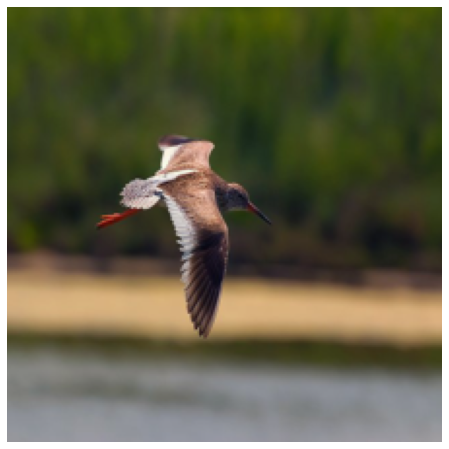

In [ ]:
#@title Load second example

x = load_img('Ex2')

plt.figure(1, figsize=(8, 8))
plt.imshow(imsc(x[0]))
plt.axis('off')
plt.show()

In [ ]:
#@title Run RELAX on example 2


model_name_list = ['Supervised', 'SimCLR', 'SwAV']
model_list = [load_supervised, load_simclr, load_swav]
relax_list = []

mask_bs = 100
num_batches = 30

for model_loader, model_name in zip(model_list, model_name_list):

    model = model_loader()

    with torch.no_grad():
        
        relax = RELAX(x, model, num_batches, mask_bs)
        relax.forward()

    relax_list.append(relax)


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/saving.py:213: UserWarning: Found keys that are not in the model state dict but in the checkpoint: ['non_linear_evaluator.block_forward.2.weight', 'non_linear_evaluator.block_forward.2.bias']
  f"Found keys that are not in the model state dict but in the checkpoint: {keys.unexpected_keys}"


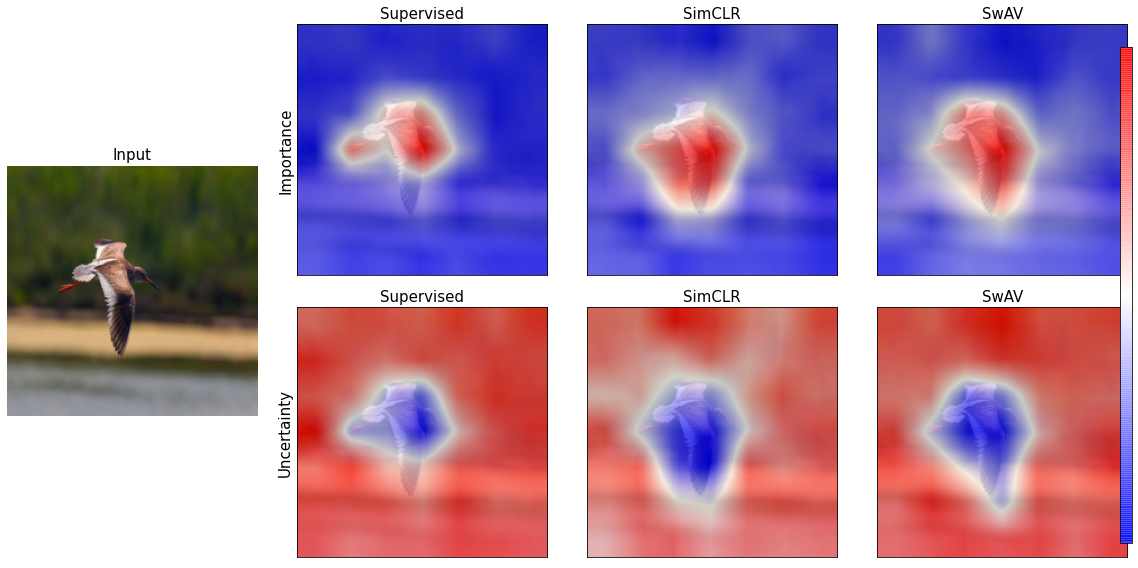

In [ ]:
#@title Display results for example 2.

import matplotlib.gridspec as gridspec

def to_np(x):
    return x.cpu().detach().numpy()

fig = plt.figure(1, figsize=(16, 8))

font_size = 15

gs = gridspec.GridSpec(4, 8)
ax1a = plt.subplot(gs[1:3, 0:2])
ax1a.imshow(imsc(x[0]))
ax1a.axis('off')
ax1a.set_title('Input', fontsize=font_size)

for idx, (model_explanation, model_name) in enumerate(zip(relax_list, model_name_list)):

    ax = plt.subplot(gs[0:2, 2*(1+idx):2*(2+idx)])
    if idx == 0: ax.set_ylabel('Importance', fontsize=font_size)

    ax.imshow(imsc(x[0]))
    im = ax.imshow(to_np(model_explanation.importance()), alpha=0.75, cmap='bwr')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(model_name, fontsize=font_size)

    ax = plt.subplot(gs[2:4, 2*(1+idx):2*(2+idx)])
    if idx == 0: ax.set_ylabel('Uncertainty', fontsize=font_size)

    ax.imshow(imsc(x[0]))

    ax.imshow(to_np(model_explanation.uncertainty()), alpha=0.75, cmap='bwr')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(model_name, fontsize=font_size)

plt.tight_layout()

cbar_ax = fig.add_axes([0.98, 0.05, 0.01, 0.86])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_ticks([])

plt.savefig('Example5.pdf', bbox_inches='tight')
plt.show()



In [ ]:
#@title Load third example

x = load_img('Ex3')

plt.figure(1, figsize=(8, 8))
plt.imshow(imsc(x[0]))
plt.axis('off')
plt.show()

In [ ]:
#@title Run RELAX on example 3


model_name_list = ['Supervised', 'SimCLR', 'SwAV']
model_list = [load_supervised, load_simclr, load_swav]
relax_list = []

mask_bs = 100
num_batches = 30

for model_loader, model_name in zip(model_list, model_name_list):

    model = model_loader()

    with torch.no_grad():
        
        relax = RELAX(x, model, num_batches, mask_bs)
        relax.forward()

    relax_list.append(relax)


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/saving.py:213: UserWarning: Found keys that are not in the model state dict but in the checkpoint: ['non_linear_evaluator.block_forward.2.weight', 'non_linear_evaluator.block_forward.2.bias']
  f"Found keys that are not in the model state dict but in the checkpoint: {keys.unexpected_keys}"


In [ ]:
#@title Display results for example 3.

import matplotlib.gridspec as gridspec

def to_np(x):
    return x.cpu().detach().numpy()

fig = plt.figure(1, figsize=(16, 8))

font_size = 15

gs = gridspec.GridSpec(4, 8)
ax1a = plt.subplot(gs[1:3, 0:2])
ax1a.imshow(imsc(x[0]))
ax1a.axis('off')
ax1a.set_title('Input', fontsize=font_size)

for idx, (model_explanation, model_name) in enumerate(zip(relax_list, model_name_list)):

    ax = plt.subplot(gs[0:2, 2*(1+idx):2*(2+idx)])
    if idx == 0: ax.set_ylabel('Importance', fontsize=font_size)

    ax.imshow(imsc(x[0]))
    im = ax.imshow(to_np(model_explanation.importance()), alpha=0.75, cmap='bwr')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(model_name, fontsize=font_size)

    ax = plt.subplot(gs[2:4, 2*(1+idx):2*(2+idx)])
    if idx == 0: ax.set_ylabel('Uncertainty', fontsize=font_size)

    ax.imshow(imsc(x[0]))

    ax.imshow(to_np(model_explanation.uncertainty()), alpha=0.75, cmap='bwr')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(model_name, fontsize=font_size)

plt.tight_layout()

cbar_ax = fig.add_axes([0.98, 0.05, 0.01, 0.86])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_ticks([])

plt.savefig('Example5.pdf', bbox_inches='tight')
plt.show()

